# Global Stock Market Analytics

in this project we will look at predicting the open direction of the Nifty 50 
index by looking at other indices and indicators. We will break the project up 
into three parts:

1. preparing the master data from the global indices
1. preliminary analysis of data
1. predictive modelling of open direction of Nifty 50
1. comparin different models at prediction
1. sentiment analysis of X / Twitter data relating to Nifty 50



## Phase 1 - prepare the master data

we begin by preparing the master data that we will be working with. We import 
the libraries we will be using, and declare some constants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import yfinance as yf
import ta

from scipy import stats

from statsmodels.api import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split



plt.style.use("ggplot")
sns.set_style("darkgrid")
sns.set_context("paper")


INDICES  = ['NSEI', 'DJI', 'IXIC', 'HSI', 'N225', 'GDAXI', 'VIX']
COLUMNS  = [f"{index}_DAILY_RETURNS" for index in INDICES]

next, we declare a function that we will use to download the OHLC data:

In [2]:

def retrieve_data(index, start_date = '2017-12-1', end_date = '2024-1-31', progress = False):
    data = yf.download(f'^{index}', start_date, end_date, progress = progress)

    # create daily returns for each index
    data['Daily Returns'] = data.Close.pct_change() * 100

    # rename columns - prefix with index name
    data.columns = ["_".join(c.upper() for c in column.split()) for column in data.columns]
    data.columns = [f"{index}_{column}" for column in data.columns]

    return data

next, we...

In [3]:
def test_normality(data, column_name, index_name):
    print()
    print(f"\t Index {index_name}")
    print(f"\tColumn {column_name}")
    print()

    data = data[column_name].dropna()

    if data.shape[0] < 50:
        print("\t     Shapiro-Wilks Test:")
        result = stats.shapiro(data)
    else:
        print("\tKolmogorov-Smirnov Test:")
        result = sm.stats.diagnostic.lilliefors(data)

    print(f"\t                p-value: {result[1]}")

    if result[1] < 0.05:
        print("\treject null hypothesis - data is not drawn from a normal distribution")
    else:
        print("\tfail to reject null hypothesis - data is drawn from a normal distribution")

    print()

next, we...

In [4]:
def qq_plots(data, title, count = 6):
    fig, axes = plt.subplots(3, 2, sharex = True, figsize = (16, 12))
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        sm.graphics.qqplot(data[index][COLUMNS[index]].dropna(), line = "45", fit = True, ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")

next, we...

In [5]:
def merge_data(data, start_date = '2018-01-02', end_date = '2023-12-29'):
    # merge data with outer join
    merged = pd.concat(data, axis = 1)

    # impute missing data using LOCF (forward fill)
    merged.ffill(inplace = True)

    # add indicators for MONTH, QUARTER, and YEAR
    merged['MONTH']   = merged.index.month
    merged['QUARTER'] = merged.index.quarter
    merged['YEAR']    = merged.index.year

    return merged[start_date:end_date]

next, we...

In [6]:
data = [retrieve_data(index) for index in INDICES]

next, we...

In [7]:
for d, c, i in zip(data, COLUMNS, INDICES):
    # check daily returns follows Normal distribution
    test_normality(d, c, i)


	 Index NSEI
	Column NSEI_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index DJI
	Column DJI_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index IXIC
	Column IXIC_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index HSI
	Column HSI_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index N225
	Column N225_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index GDAXI
	Column GDAXI_DAILY_RETURNS

	Kolmogorov-Smirnov 

next, we...

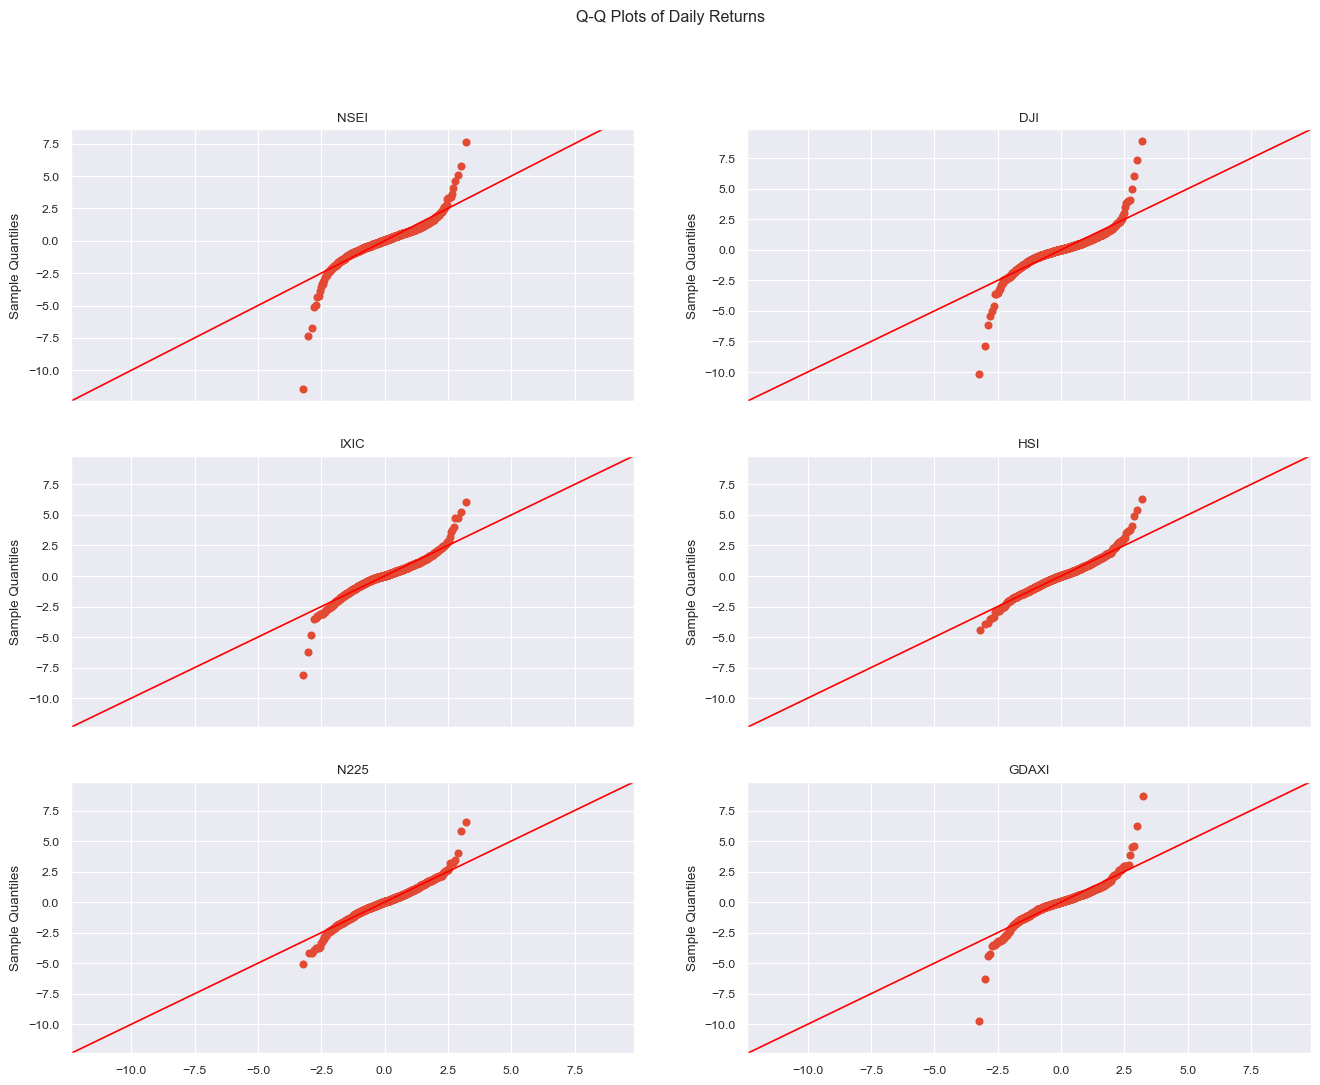

In [8]:
# check daily returns follows Normal distribution
qq_plots(data, "Q-Q Plots of Daily Returns")

next, we...

In [9]:
master = merge_data(data)

## Phase 2 - preliminary analysis

In [10]:
CONDITIONS = [(master.index <= '2020-01-30'), ('2022-05-05' <= master.index)]
CHOICES    = ['PRE_COVID', 'POST_COVID']

next, we...

In [11]:
master['PANDEMIC'] = np.select(CONDITIONS, CHOICES, 'COVID')
master['PANDEMIC'] = pd.Categorical(master['PANDEMIC'], categories = ['PRE_COVID', 'COVID', 'POST_COVID'], ordered = True)

next, we...

In [12]:
master["NSEI_OPEN_DIR"] = np.where(master["NSEI_OPEN"] > master["NSEI_CLOSE"].shift(), 1, 0)

next, we...

In [13]:
def performance_analytics_tables(data, group_by, count = 6):
    for index in range(count):
        table = data.groupby(group_by, observed = False)[COLUMNS[index]].agg(['count', 'mean', 'std', 'var'])
        print(f"\n{INDICES[index]}\n\n{table}\n\n")

next, we...

In [14]:
def performance_analytics_box_plots(data, group_by, title, count = 6):
    fig, axes = plt.subplots(3, 2, sharex = True, figsize = (16, 12))
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        sns.boxplot(x = data[group_by], y = data[COLUMNS[index]], ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")

next, we...

In [15]:
def performance_analytics_bar_plots(data, group_by, title, count = 6, aggfunc = "median"):
    fig, axes = plt.subplots(3, 2, sharex = True, figsize = (16, 12))
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        table = data.groupby(group_by, observed = False)[COLUMNS[index]].agg([aggfunc])
        sns.barplot(x = table.index, y = table[aggfunc], ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")

next, we...

In [16]:
def performance_analytics_heat_maps(data, group_by, title, column = "QUARTER", count = 6, aggfunc = "median"):
    fig, axes = plt.subplots(3, 2, sharex = True, figsize = (16, 12))
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        table = pd.pivot_table(data, values = COLUMNS[index], index = [group_by], columns = [column], aggfunc = aggfunc, observed = False)
        sns.heatmap(table, ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")

next, we...

In [17]:
def correlation_matrix(data):
    plt.figure(figsize = (9, 6))
    matrix = data[COLUMNS[:-1]].corr()

    ax = sns.heatmap(matrix, annot = True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation = 30,
        horizontalalignment = "right"
    )

next, we...

In [18]:
performance_analytics_tables(master, "YEAR")


NSEI

      count      mean       std       var
YEAR                                     
2018    260  0.011858  0.804320  0.646931
2019    260  0.061655  0.862269  0.743508
2020    262  0.059276  2.003775  4.015114
2021    261  0.093951  0.979932  0.960268
2022    260  0.054513  1.096428  1.202155
2023    260  0.079254  0.620049  0.384461



DJI

      count      mean       std       var
YEAR                                     
2018    260 -0.034755  1.142622  1.305584
2019    260  0.098867  0.783563  0.613972
2020    262  0.056509  2.277254  5.185886
2021    261  0.074976  0.772875  0.597336
2022    260 -0.024515  1.237294  1.530896
2023    260  0.059685  0.708875  0.502504



IXIC

      count      mean       std       var
YEAR                                     
2018    260 -0.020231  1.329736  1.768199
2019    260  0.132933  0.974714  0.950068
2020    262  0.170412  2.199609  4.838279
2021    261  0.095541  1.123517  1.262289
2022    260 -0.124394  2.000332  4.001327
2023    26

next, we...

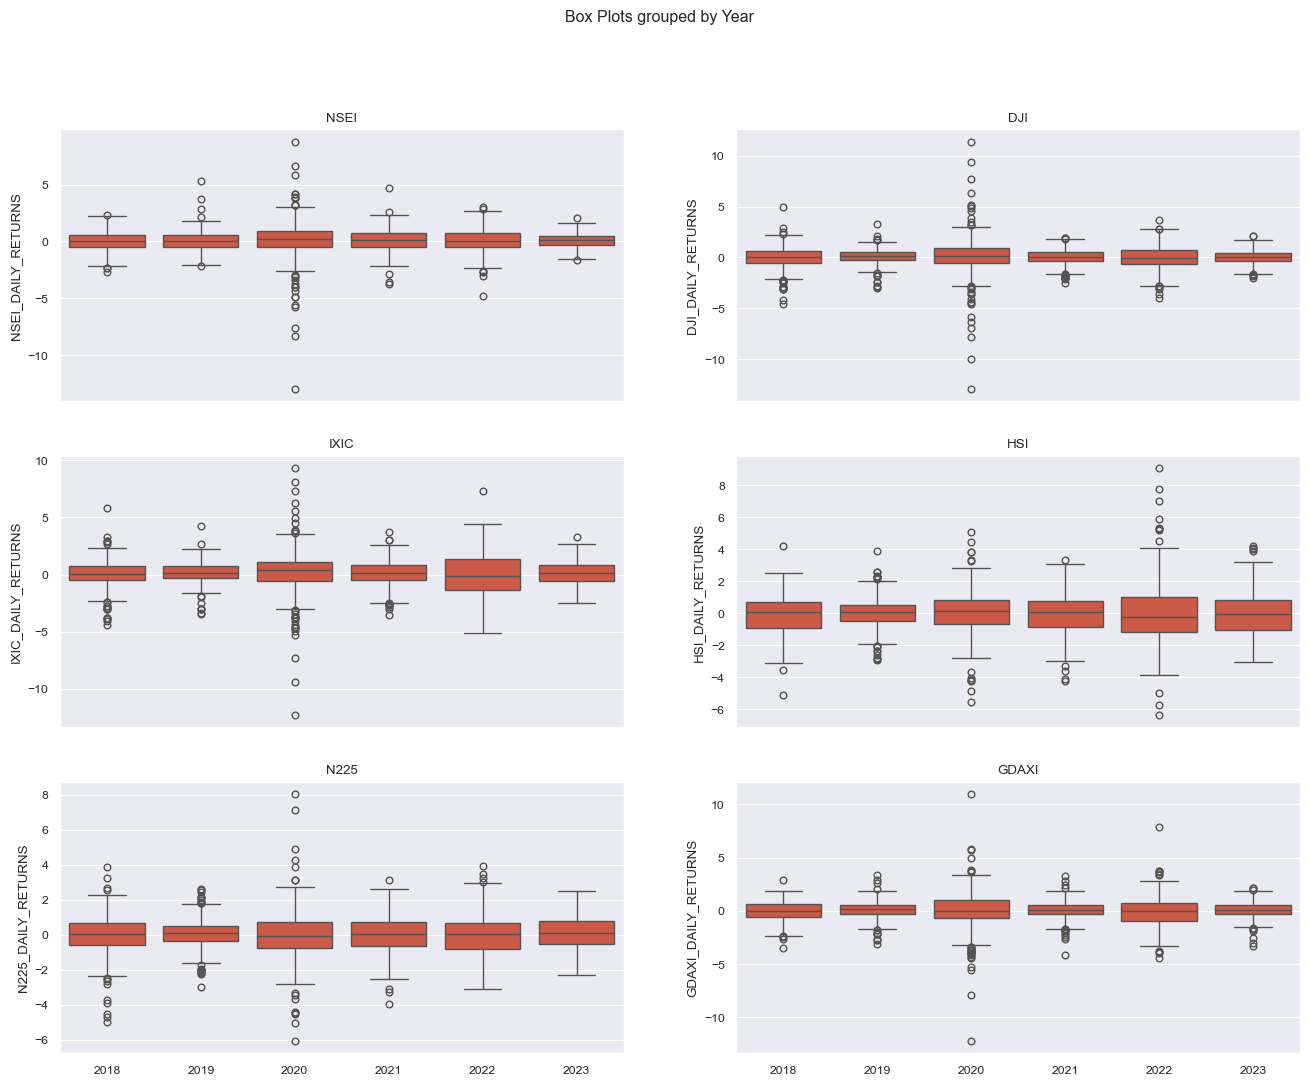

In [19]:
performance_analytics_box_plots(master, "YEAR", "Box Plots grouped by Year")

next, we...

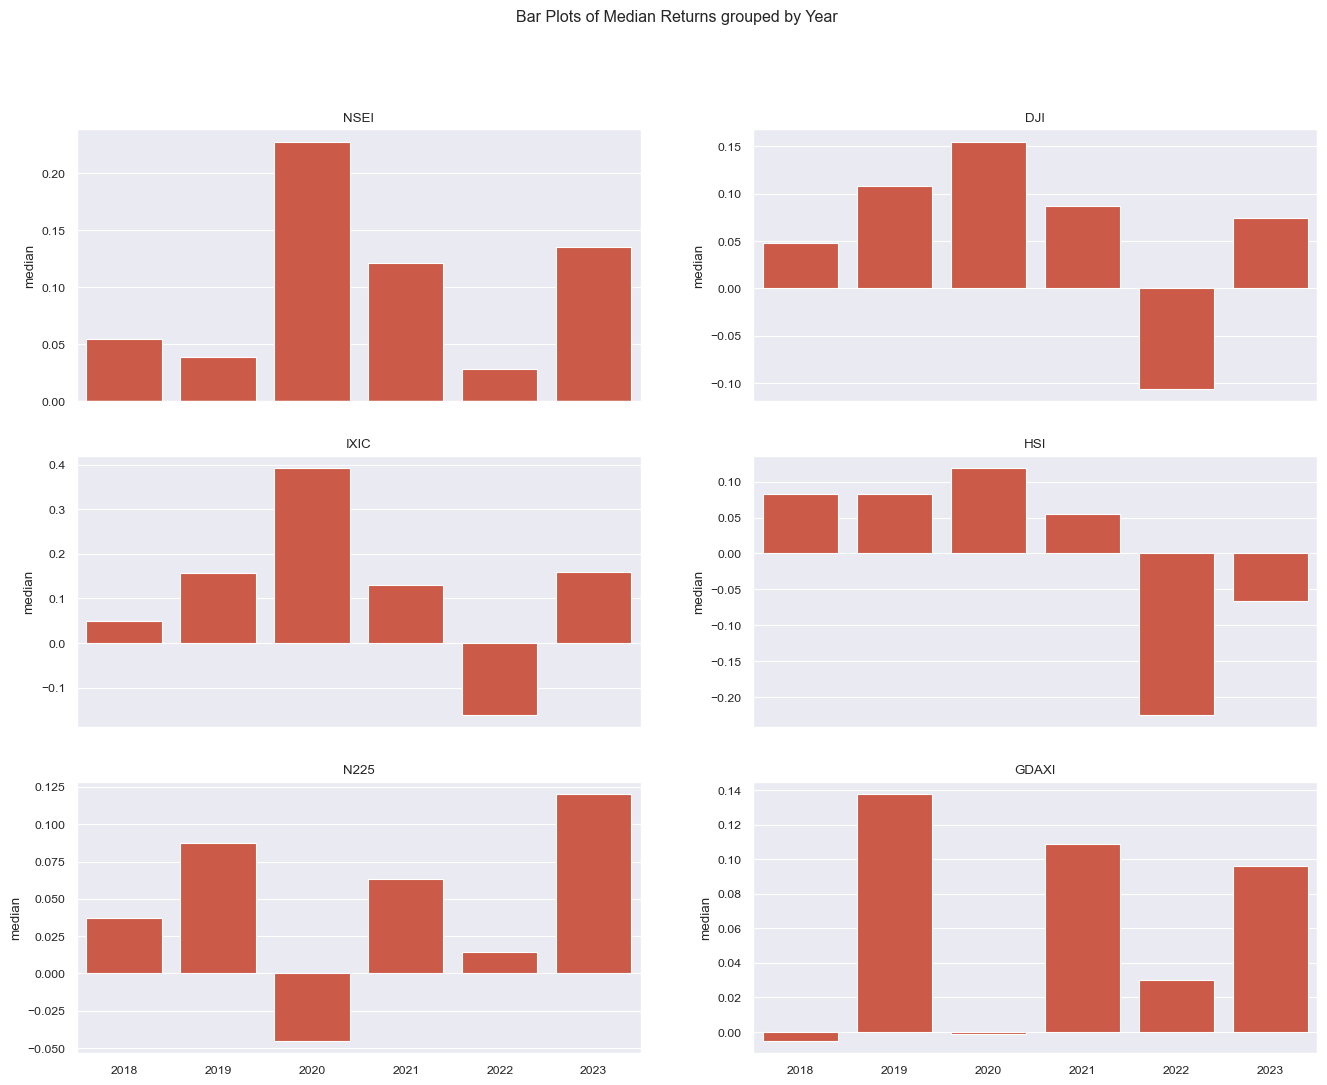

In [20]:
performance_analytics_bar_plots(master, "YEAR", "Bar Plots of Median Returns grouped by Year")

next, we...

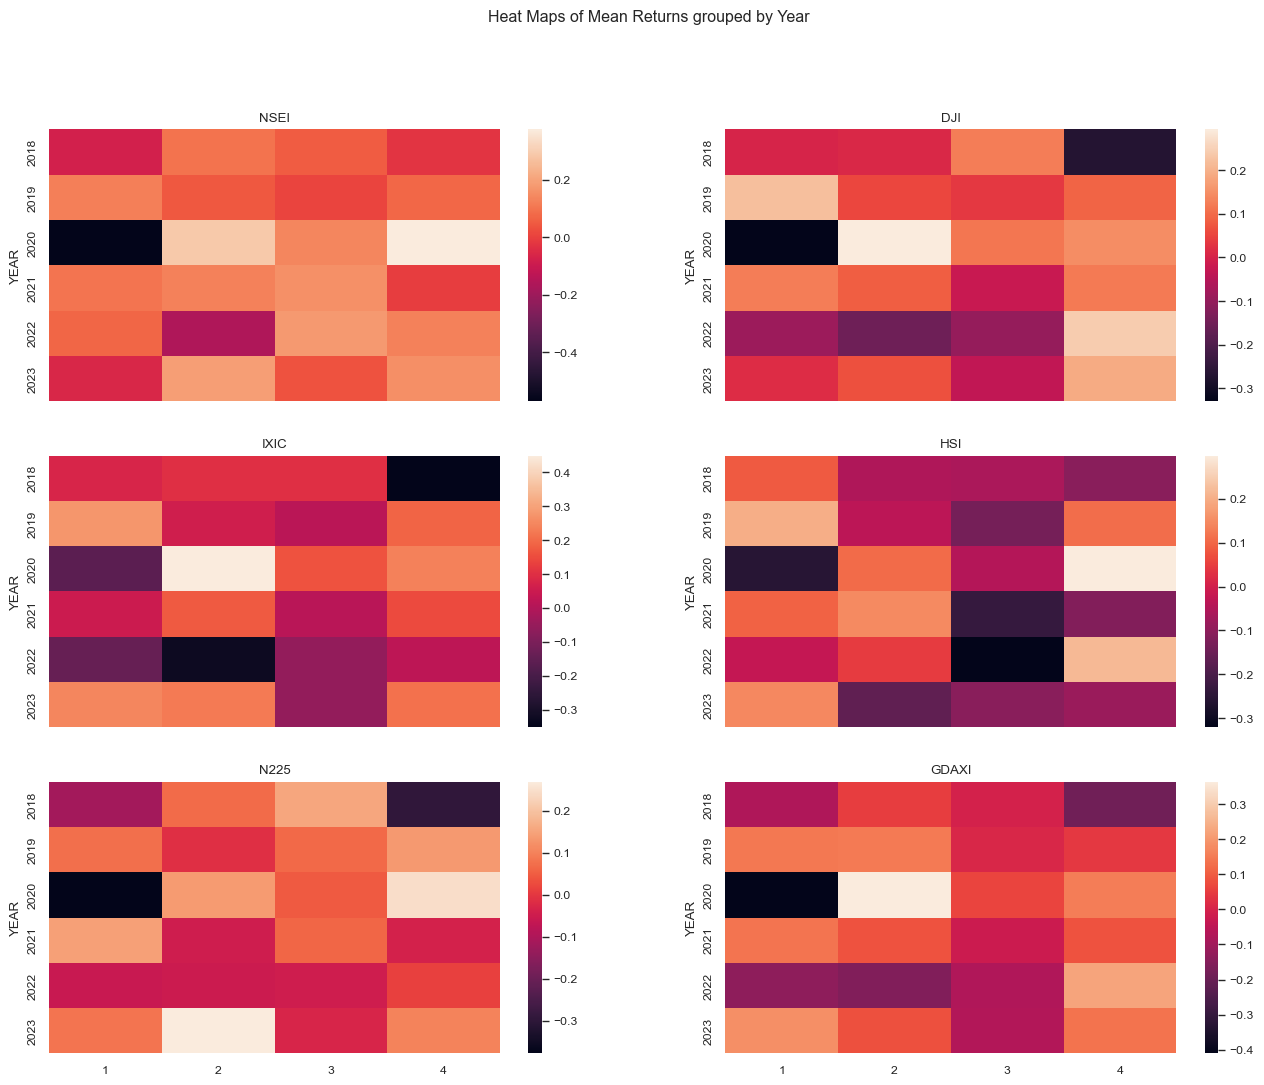

In [21]:
performance_analytics_heat_maps(master, "YEAR", "Heat Maps of Mean Returns grouped by Year", aggfunc = "mean")

next, we...

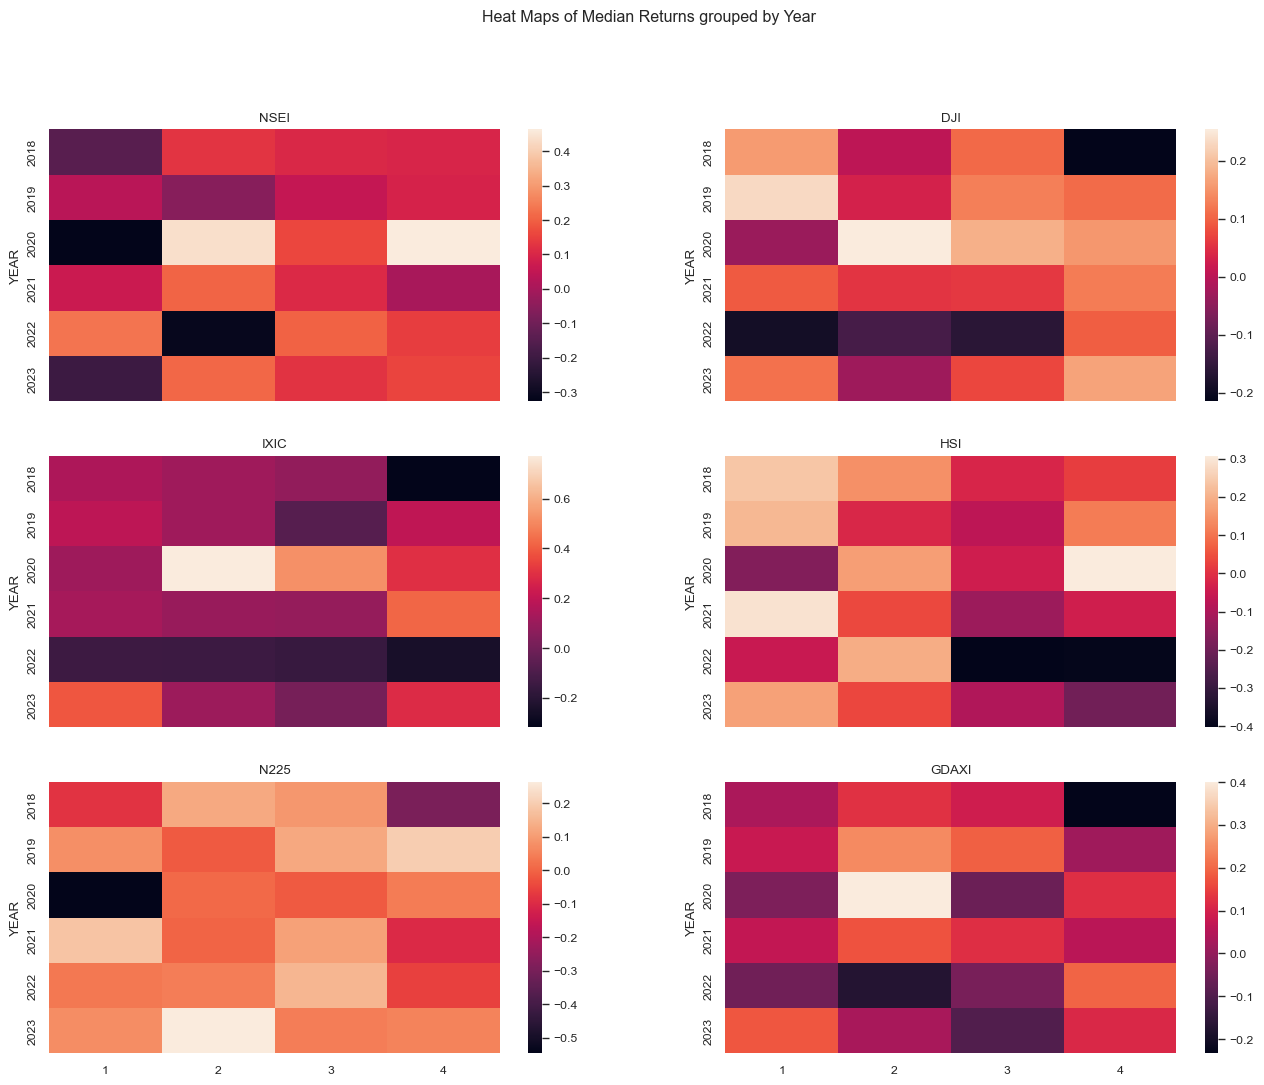

In [22]:
performance_analytics_heat_maps(master, "YEAR", "Heat Maps of Median Returns grouped by Year")

next, we...

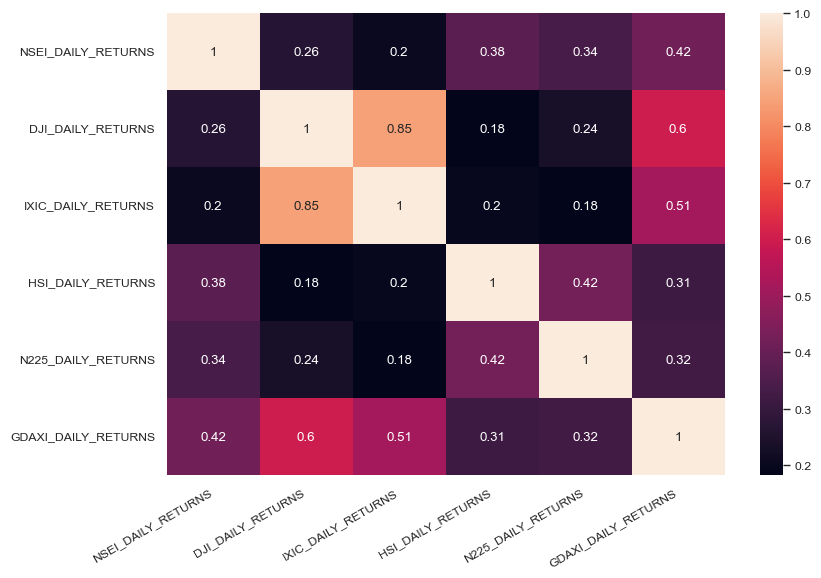

In [23]:
correlation_matrix(master)

next, we...

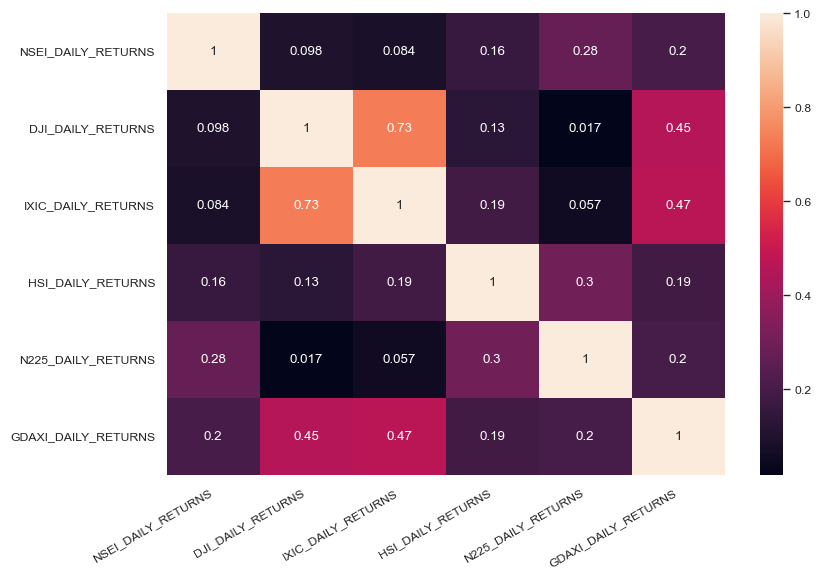

In [24]:
correlation_matrix(master['2023-01-02':'2023-12-29'])

next, we...

In [25]:
performance_analytics_tables(master, "PANDEMIC")


NSEI

            count      mean       std       var
PANDEMIC                                       
PRE_COVID     542  0.033358  0.830382  0.689535
COVID         589  0.068626  1.562565  2.441611
POST_COVID    432  0.082045  0.777193  0.604029



DJI

            count      mean       std       var
PANDEMIC                                       
PRE_COVID     542  0.033705  0.968612  0.938208
COVID         589  0.042948  1.656938  2.745443
POST_COVID    432  0.038478  0.980846  0.962060



IXIC

            count      mean       std       var
PANDEMIC                                       
PRE_COVID     542  0.061950  1.153434  1.330409
COVID         589  0.077150  1.812437  3.284927
POST_COVID    432  0.065371  1.525190  2.326205



HSI

            count      mean       std       var
PANDEMIC                                       
PRE_COVID     542 -0.012615  1.126131  1.268172
COVID         589  0.011764  1.507990  2.274035
POST_COVID    432 -0.046861  1.664055  2.769080



N225


next, we...

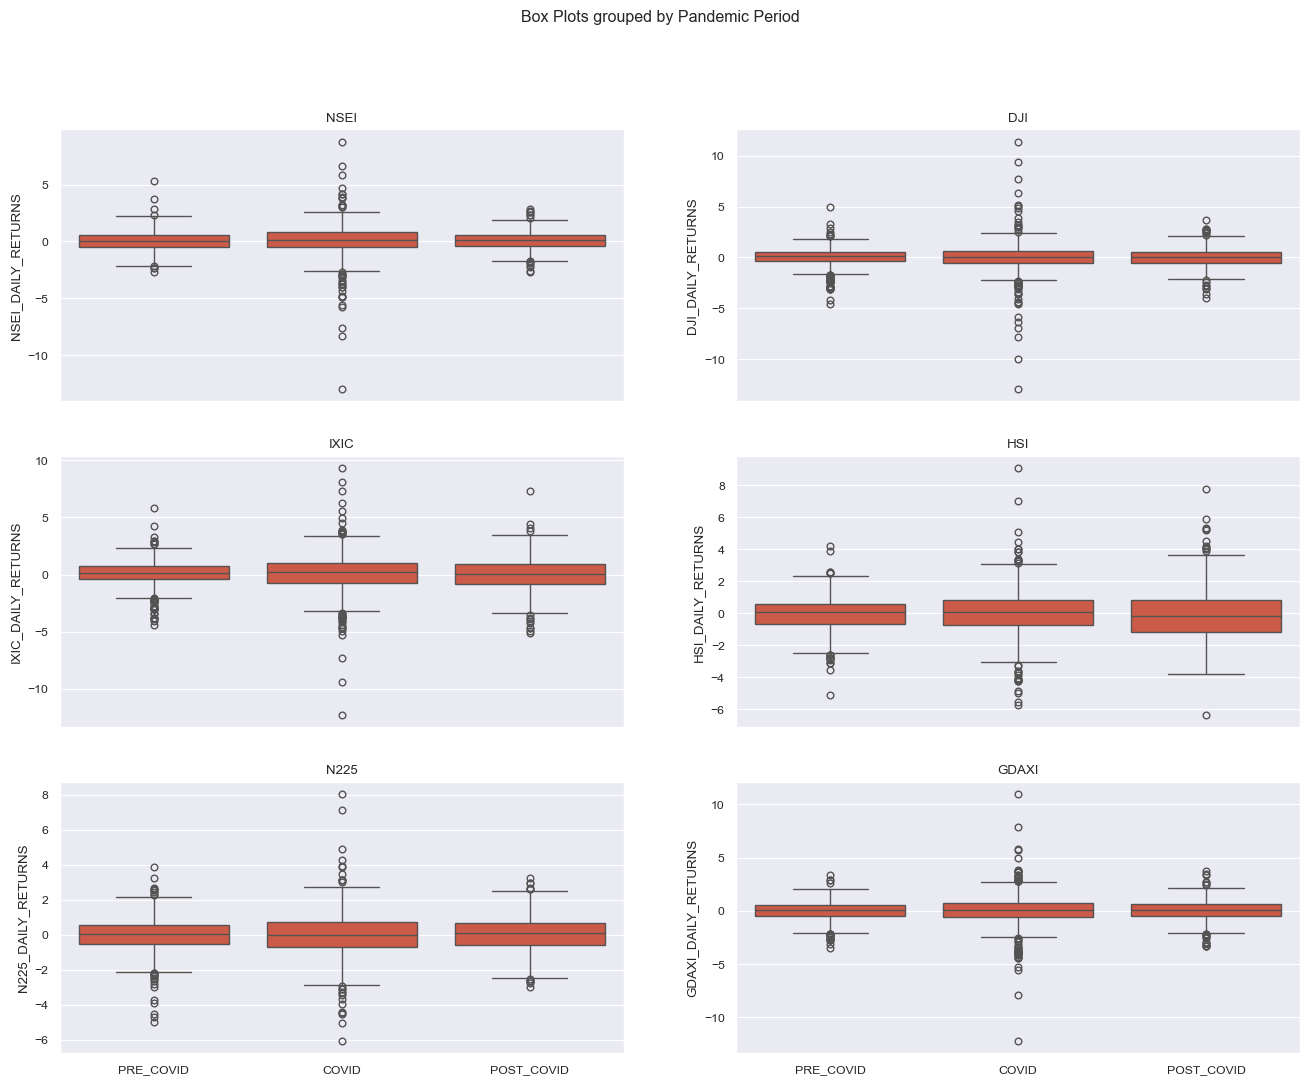

In [26]:
performance_analytics_box_plots(master, "PANDEMIC", "Box Plots grouped by Pandemic Period")

next, we...

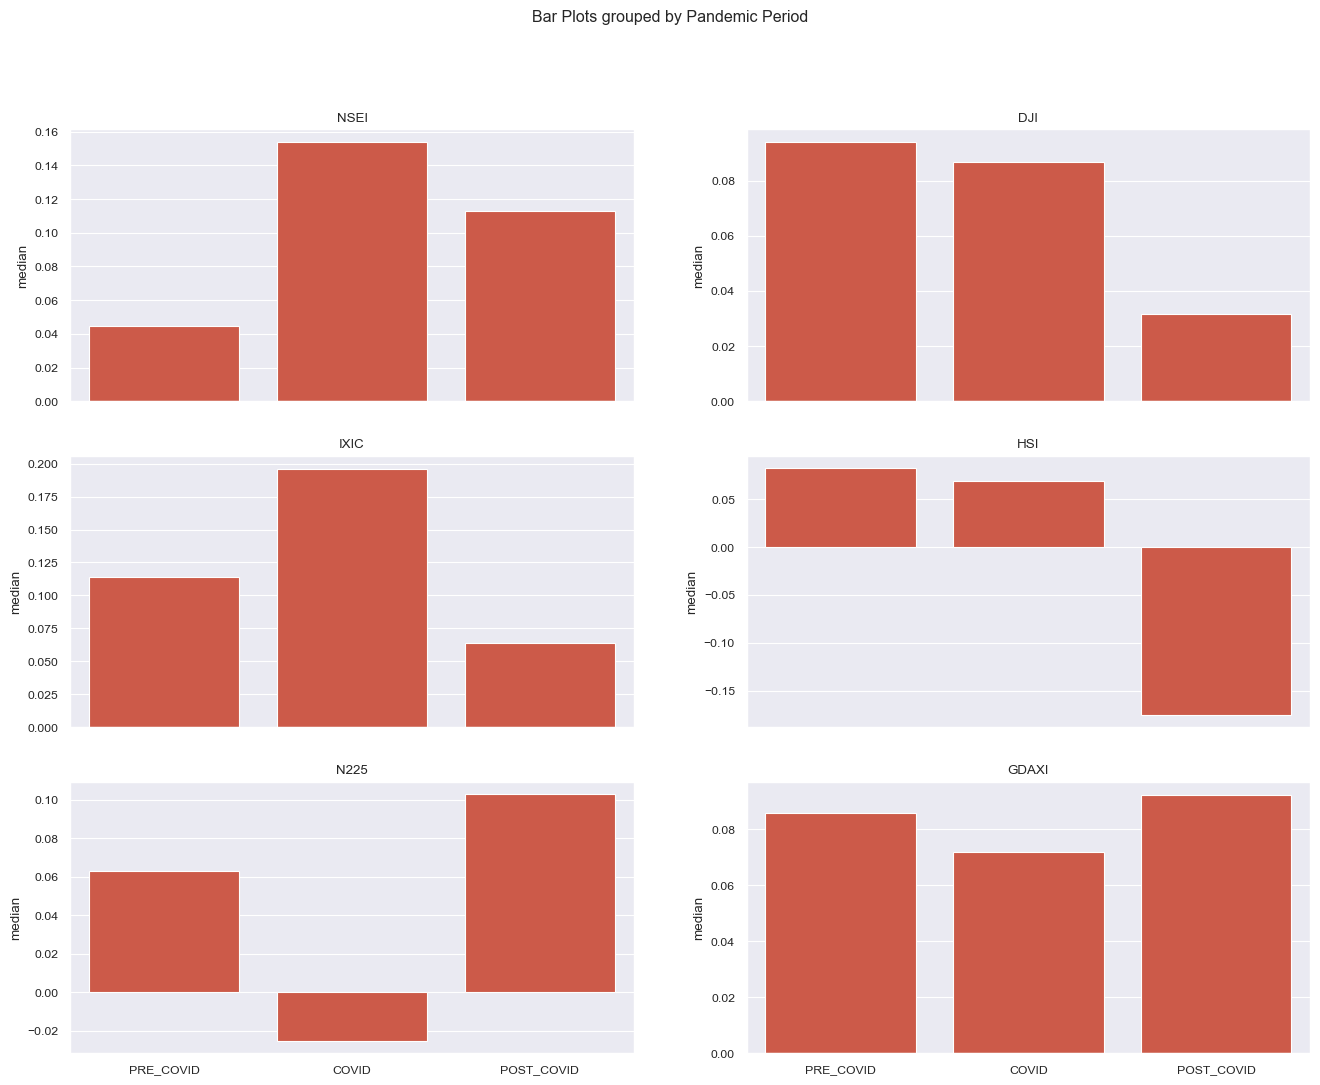

In [27]:
performance_analytics_bar_plots(master, "PANDEMIC", "Bar Plots grouped by Pandemic Period")

next, we...

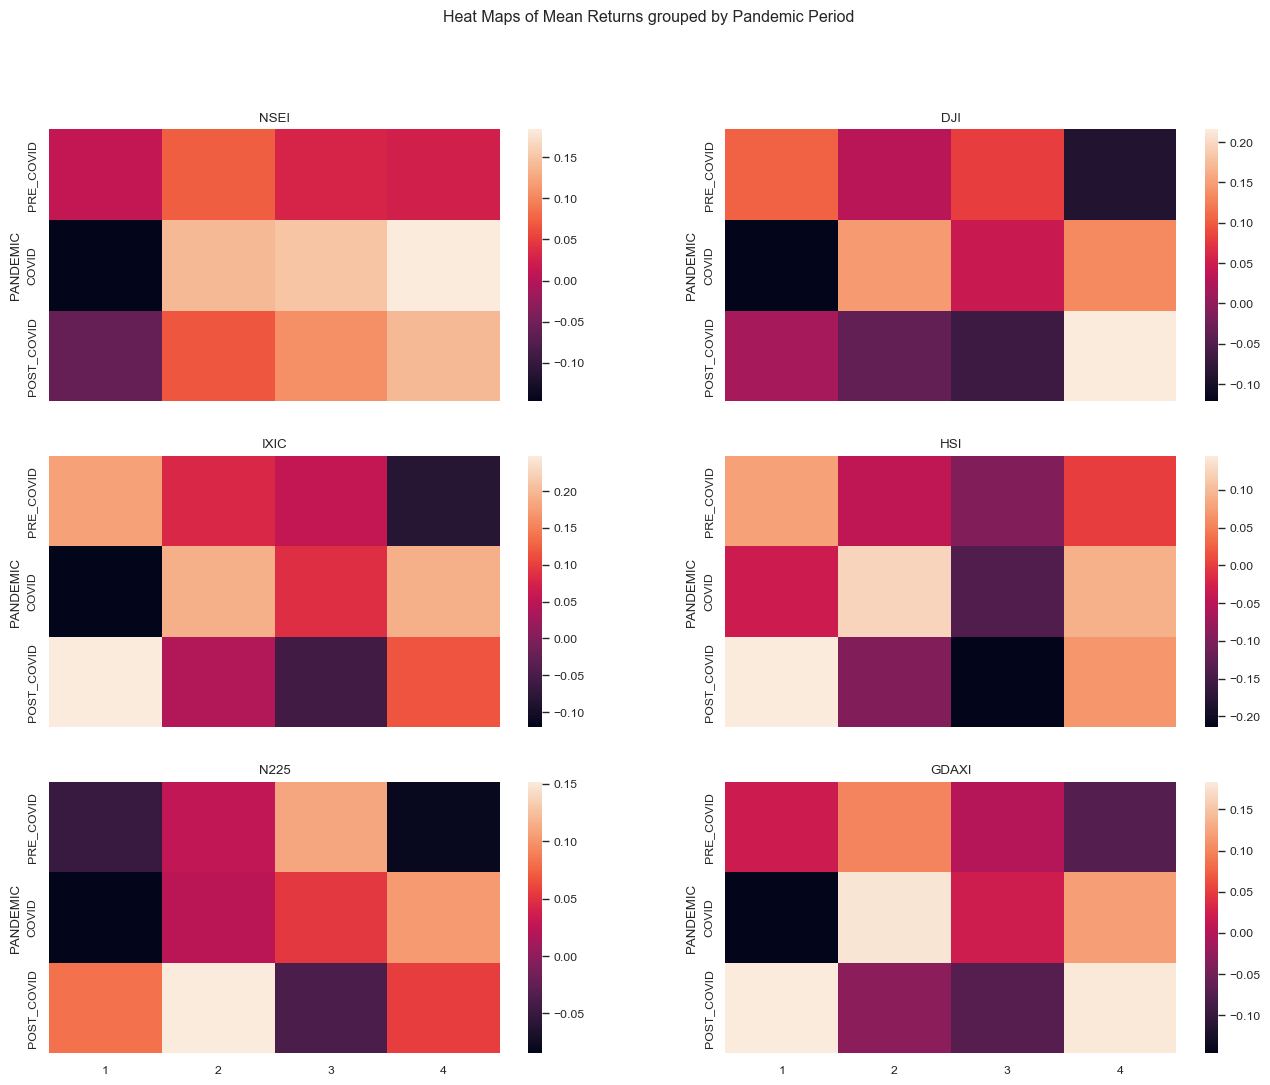

In [28]:
performance_analytics_heat_maps(master, "PANDEMIC", "Heat Maps of Mean Returns grouped by Pandemic Period", aggfunc = "mean")

next, we...

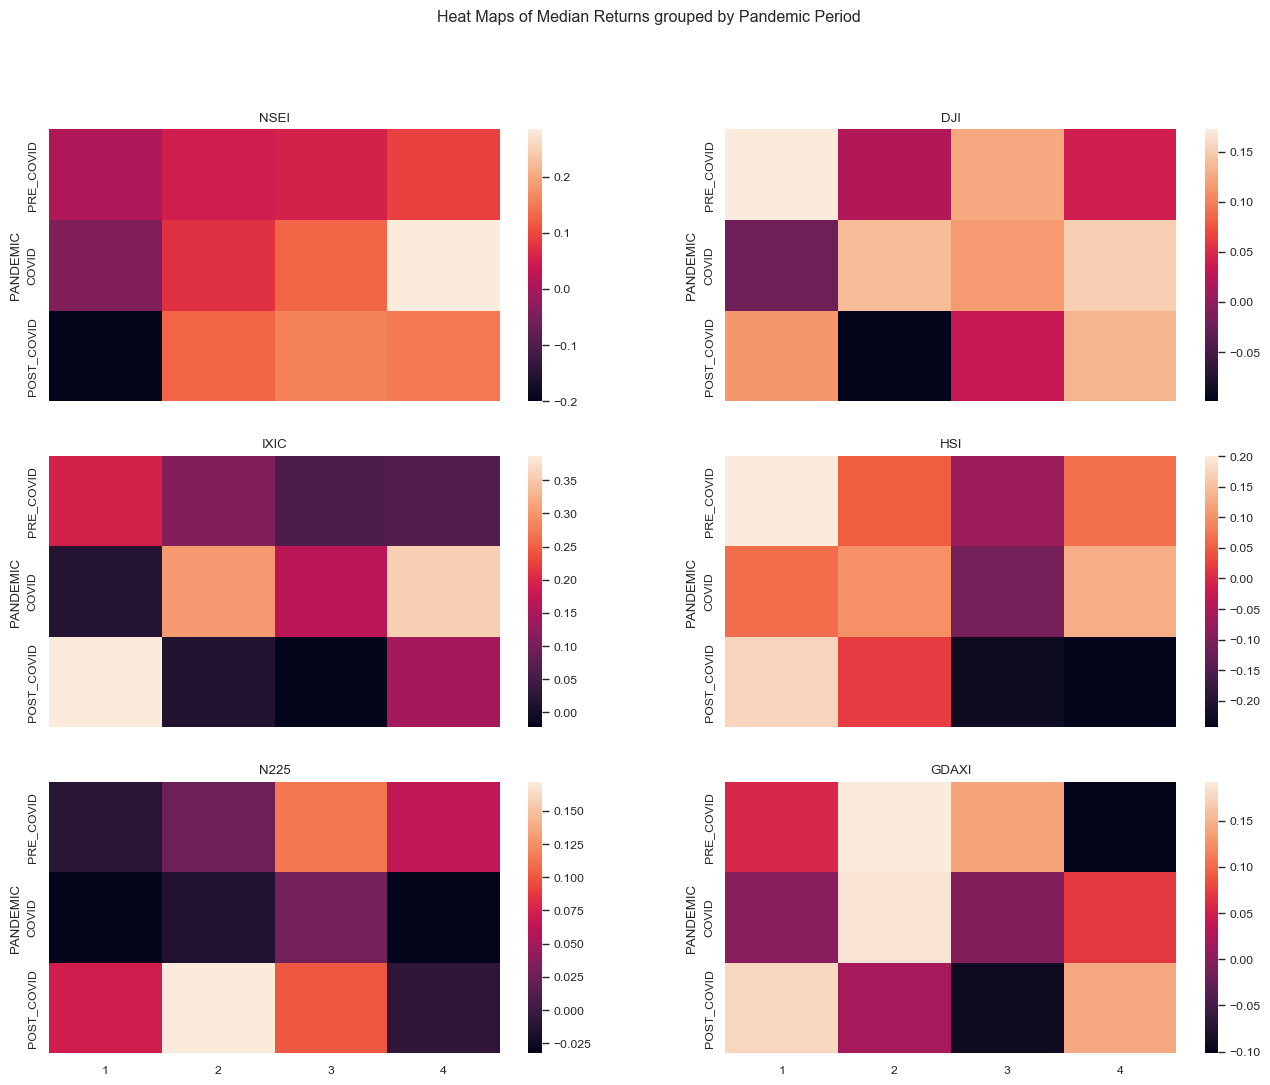

In [29]:
performance_analytics_heat_maps(master, "PANDEMIC", "Heat Maps of Median Returns grouped by Pandemic Period")

next, we...

In [30]:
for i in range(6):
    pre_covid  = master.loc[(master['PANDEMIC'] == 'PRE_COVID'),  [COLUMNS[i]]]
    post_covid = master.loc[(master['PANDEMIC'] == 'POST_COVID'), [COLUMNS[i]]]

    mean_pre   = pre_covid.values.mean()
    post_count = np.where(post_covid[COLUMNS[i]].ge(mean_pre).values == True)[0][0]
    post_date  = post_covid.index[post_covid[COLUMNS[i]].ge(mean_pre)][0].date()

    print(f"{INDICES[i].rjust(5)} returned to pre-covid levels (mean {mean_pre: 2.4f}) on {post_date} after {post_count} trading day(s)")

 NSEI returned to pre-covid levels (mean  0.0334) on 2022-05-16 after 7 trading day(s)
  DJI returned to pre-covid levels (mean  0.0337) on 2022-05-13 after 6 trading day(s)
 IXIC returned to pre-covid levels (mean  0.0619) on 2022-05-10 after 3 trading day(s)
  HSI returned to pre-covid levels (mean -0.0126) on 2022-05-11 after 4 trading day(s)
 N225 returned to pre-covid levels (mean  0.0001) on 2022-05-06 after 1 trading day(s)
GDAXI returned to pre-covid levels (mean  0.0114) on 2022-05-10 after 3 trading day(s)


next, we...

In [31]:
table1 = master.groupby("YEAR", observed = False)[["NSEI_OPEN_DIR"]].sum()
table2 = master.groupby("YEAR", observed = False)[["NSEI_OPEN_DIR"]].count()
table  = ((table1["NSEI_OPEN_DIR"] / table2["NSEI_OPEN_DIR"]) * 100).round(2)

print("\nNifty Fifty Daily Movement\n")
print(f"\n{table}\n")


Nifty Fifty Daily Movement


YEAR
2018    70.38
2019    69.23
2020    70.61
2021    71.65
2022    59.23
2023    67.31
Name: NSEI_OPEN_DIR, dtype: float64



next we...

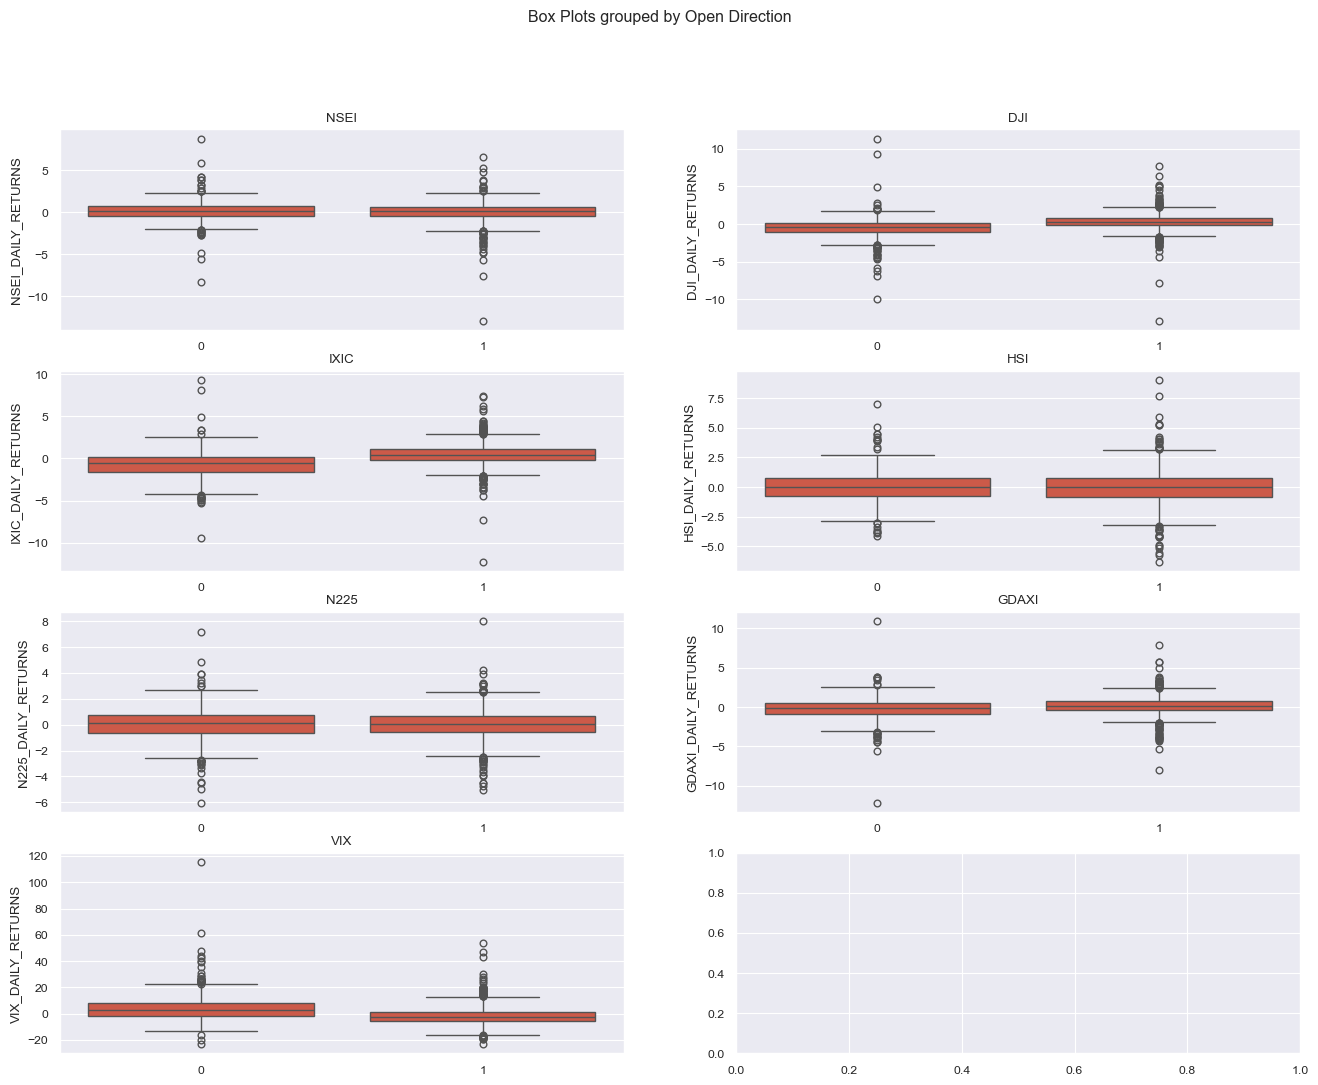

In [32]:
fig, axes = plt.subplots(4, 2, figsize = (16, 12))
fig.suptitle("Box Plots grouped by Open Direction")

for index in range(7):
    axes[index // 2, index % 2].set_title(INDICES[index])
    sns.boxplot(x = master["NSEI_OPEN_DIR"], y = master[COLUMNS[index]].shift(), ax = axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_xlabel("")

## Phase 3 - training a logistic model

Next we add some indicators and ratios

In [34]:
RATIOS     = ["NSEI_HL_RATIO", "DJI_HL_RATIO"]
INDICATORS = ["NSEI_RSI", "DJI_RSI", "NSEI_TSI", "DJI_TSI"]
ALL_COLS   = COLUMNS + RATIOS + INDICATORS

next, we...

In [35]:
master["NSEI_HL_RATIO"] = master["NSEI_HIGH"] / master["NSEI_LOW"]
master["DJI_HL_RATIO"]  = master["DJI_HIGH"]  / master["DJI_LOW"]

next, we...

In [36]:
master["NSEI_RSI"] = ta.momentum.rsi(master["NSEI_CLOSE"])
master["DJI_RSI"]  = ta.momentum.rsi(master["DJI_CLOSE"])

master["NSEI_TSI"] = ta.momentum.tsi(master["NSEI_CLOSE"])
master["DJI_TSI"]  = ta.momentum.tsi(master["DJI_CLOSE"])

next, we...

In [38]:
data = pd.concat([master["NSEI_OPEN_DIR"].shift(-1), master[ALL_COLS]], axis = 1)
data.dropna(inplace = True)
data.head()

,NSEI_OPEN_DIR,NSEI_DAILY_RETURNS,DJI_DAILY_RETURNS,IXIC_DAILY_RETURNS,HSI_DAILY_RETURNS,N225_DAILY_RETURNS,GDAXI_DAILY_RETURNS,VIX_DAILY_RETURNS,NSEI_HL_RATIO,DJI_HL_RATIO,NSEI_RSI,DJI_RSI,NSEI_TSI,DJI_TSI
Date,,,,,,,,,,,,,,
2018-02-22,1.0,-0.141862,0.664177,-0.112772,-1.483242,-1.066738,-0.068803,-6.493512,1.005502,1.012146,35.462139,46.645122,-30.229045,-9.335285
2018-02-23,1.0,1.043559,1.392128,1.765585,0.973627,0.719252,0.175574,-11.912391,1.009854,1.011394,43.991068,52.167111,-27.688141,-7.175461
2018-02-26,1.0,0.872647,1.577556,1.145773,0.740168,1.191496,0.346449,-4.184352,1.006915,1.013160,50.003304,57.597238,-23.576140,-3.663260
2018-02-27,0.0,-0.267418,-1.163939,-1.227654,-0.729999,1.066320,-0.289850,17.658227,1.008959,1.015449,48.278103,52.762870,-20.700940,-2.074670
2018-02-28,0.0,-0.582229,-1.498739,-0.782232,-1.355797,-1.436450,-0.439373,6.777839,1.007069,1.022129,44.673823,47.319430,-19.286991,-2.368269


next, we...

In [39]:
X = data[ALL_COLS]
y = data['NSEI_OPEN_DIR']

next, we...

In [40]:
X.insert(loc = 0, column = "Intercept", value = 1)

next, we...

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337)

next, we...

In [43]:
def prune(X, y, verbose = True):
    dropped = []
    while True:
        model = Logit(y, X).fit(disp = 0)

        insignificant = [p for p in zip(model.pvalues.index[1:], model.pvalues[1:]) if p[1] > 0.05]

        values   = [variance_inflation_factor(model.model.exog, i) for i in range(1, model.model.exog.shape[1])]
        colinear = [val for val in zip(model.model.exog_names[1:], values) if val[1] > 5]

        if insignificant:
            insignificant.sort(key = lambda p: -p[1])

            if verbose:
                print(f"dropping {insignificant[0][0]} with p-value {insignificant[0][1]}")

            X = X.drop([insignificant[0][0]], axis = 1)
            dropped.append(insignificant[0][0])

        elif colinear:
            colinear.sort(key = lambda c: -c[1])

            if verbose:
                print(f"dropping {colinear[0][0]} with vif {colinear[0][1]}")

            X = X.drop([colinear[0][0]], axis = 1)
            dropped.append(colinear[0][0])

        else:
            return model, dropped

next, we...

In [45]:
model, dropped = prune(X_train, y_train)

dropping DJI_DAILY_RETURNS with p-value 0.7234766099769976
dropping GDAXI_DAILY_RETURNS with p-value 0.6162105670377191
dropping NSEI_HL_RATIO with p-value 0.42776185052464266
dropping DJI_HL_RATIO with p-value 0.15630559889450327
dropping NSEI_DAILY_RETURNS with p-value 0.13281329048460586
dropping NSEI_TSI with vif 5.865700460659149
dropping NSEI_RSI with p-value 0.7783762272652992


next, we...

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          NSEI_OPEN_DIR   No. Observations:                 1220
Model:                          Logit   Df Residuals:                     1213
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Jun 2024   Pseudo R-squ.:                  0.1375
Time:                        20:24:32   Log-Likelihood:                -660.02
converged:                       True   LL-Null:                       -765.23
Covariance Type:            nonrobust   LLR p-value:                 1.141e-42
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4041      0.656     -2.139      0.032      -2.690      -0.118
IXIC_DAILY_RETURNS     0.4552      0.075      6.093      0.000       0.309       0.602
HSI_DAILY_RETURNS     -0.1395      0.053     -2.632      0.008      -0.243      -0.036
N225_DAILY_RETURNS    -0.1960      0.068     -2.897      0.004      -0.329      -0.063
VIX_DAILY_RETURNS     -0.0397      0.013     -3.054      0.002      -0.065      -0.014
DJI_RSI                0.0447      0.013      3.415      0.001       0.019       0.070
DJI_TSI               -0.0205      0.008     -2.660      0.008      -0.036      -0.005
======================================================================================
"""

next, we...

In [47]:
vif_data = pd.DataFrame()
vif_data["Feature"] = model.model.exog_names[1:]
vif_data["VIF"]     = [variance_inflation_factor(model.model.exog, i) for i in range(1, model.model.exog.shape[1])]
vif_data

,Feature,VIF
0,IXIC_DAILY_RETURNS,2.073867
1,HSI_DAILY_RETURNS,1.244922
2,N225_DAILY_RETURNS,1.353286
3,VIX_DAILY_RETURNS,1.994009
4,DJI_RSI,4.850250
5,DJI_TSI,4.379409


next, we...

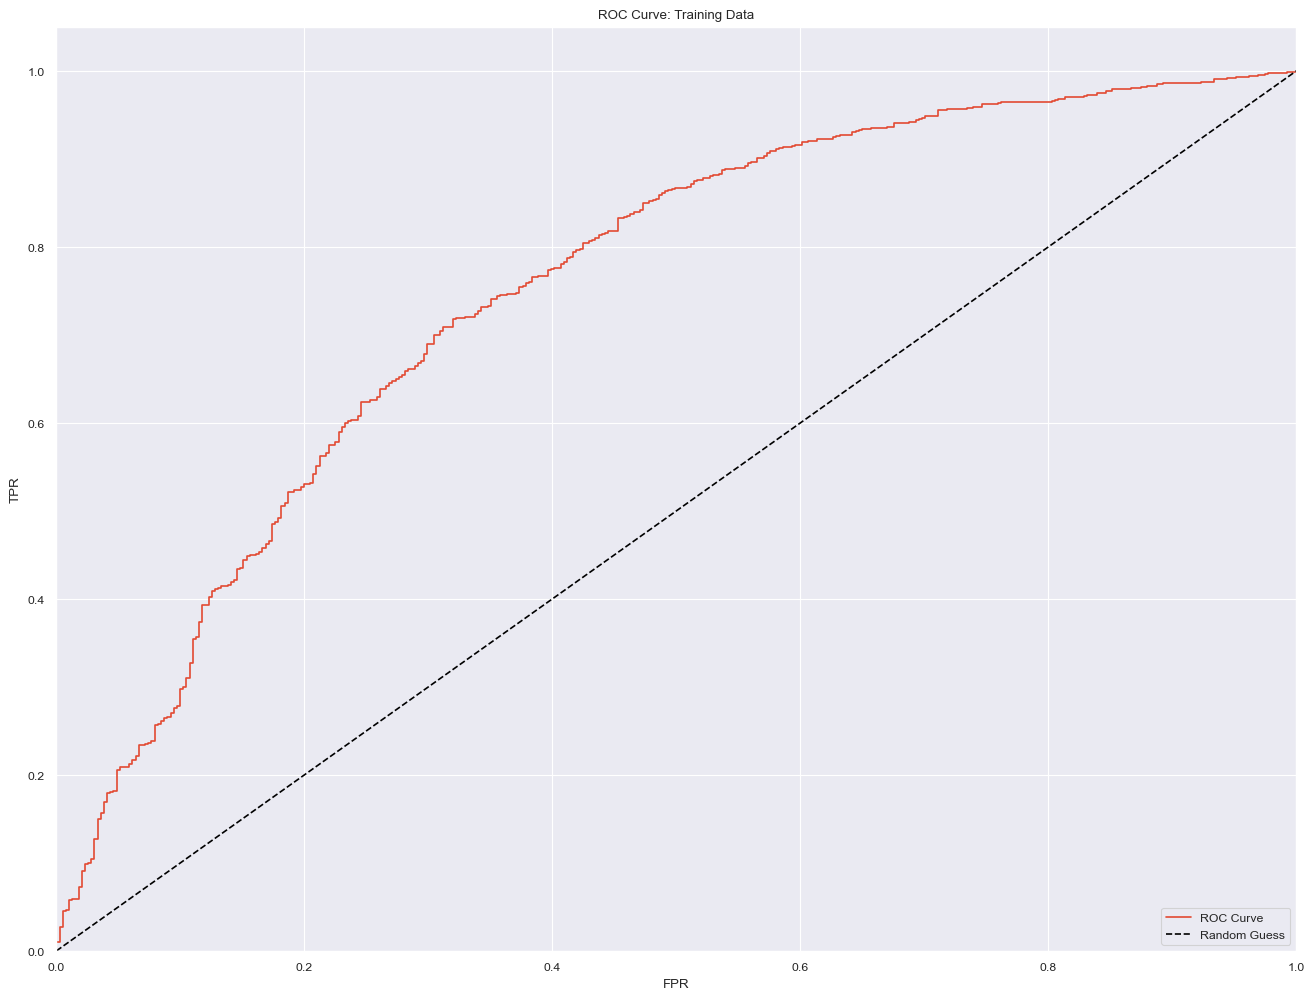

In [49]:
y_pred = model.predict(X_train.drop(dropped, axis = 1))
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

plt.figure(figsize = (16, 12))

plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title(f"ROC Curve: Training Data")
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend(loc = 'lower right')
plt.show()

next, we...

In [50]:
optimal_threshold = round(thresholds[np.argmax(tpr - fpr)], 3)
print(f'Best Threshold: {optimal_threshold}')

Best Threshold: 0.684


next, we...

In [51]:
auc_roc = roc_auc_score(y_train, y_pred)
print(f'AUC ROC: {auc_roc}')

AUC ROC: 0.7529115595469844


next, we...

In [52]:
y_pred_class = np.where(y_pred <= optimal_threshold, 0, 1)
print(classification_report(y_train, y_pred_class))

              precision    recall  f1-score   support

         0.0       0.53      0.68      0.60       391
         1.0       0.83      0.72      0.77       829

    accuracy                           0.70      1220
   macro avg       0.68      0.70      0.68      1220
weighted avg       0.73      0.70      0.71      1220



next, we...

In [53]:
table = pd.crosstab(y_pred_class, y_train)
print(table)

NSEI_OPEN_DIR  0.0  1.0
row_0                  
0              265  234
1              126  595


next, we...

In [54]:
sensitivity = round((table.iloc[1, 1] / (table.iloc[0, 1] + table.iloc[1, 1])) * 100, 2)
specificity = round((table.iloc[0, 0] / (table.iloc[0, 0] + table.iloc[1, 0])) * 100, 2)

print(f"Sensitivity: {sensitivity}%")
print(f"Specificity: {specificity}%")

Sensitivity: 71.77%
Specificity: 67.77%


next, we...

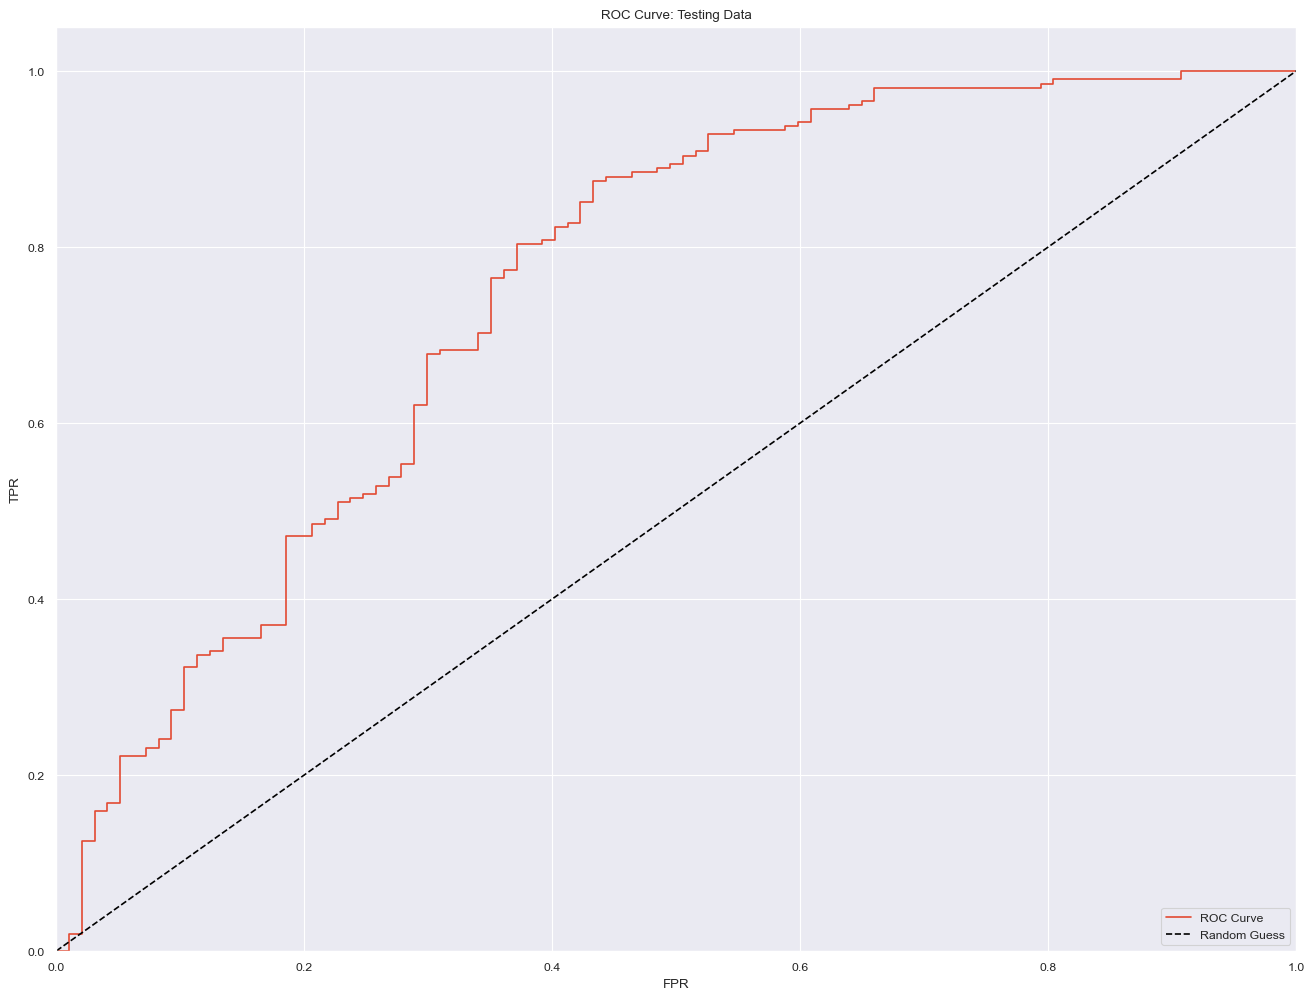

In [55]:
y_test_pred = model.predict(X_test.drop(dropped, axis = 1))

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize = (16, 12))

plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title(f"ROC Curve: Testing Data")
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend(loc = 'lower right')
plt.show()

next, we...

In [56]:
auc_roc = roc_auc_score(y_test, y_test_pred)
print(f'AUC ROC: {auc_roc}')

AUC ROC: 0.7520816812053925


next, we...

In [57]:
y_test_pred_class = np.where(y_test_pred <= optimal_threshold,  0, 1)
print(classification_report(y_test, y_test_pred_class))

              precision    recall  f1-score   support

         0.0       0.53      0.65      0.58        97
         1.0       0.82      0.73      0.77       208

    accuracy                           0.70       305
   macro avg       0.67      0.69      0.67       305
weighted avg       0.72      0.70      0.71       305



next, we...

In [59]:
table = pd.crosstab(y_test_pred_class, y_test)
print(table)

NSEI_OPEN_DIR  0.0  1.0
row_0                  
0               63   57
1               34  151


next, we...

In [60]:
sensitivity = round((table.iloc[1, 1] / (table.iloc[0, 1] + table.iloc[1, 1])) * 100, 2)
specificity = round((table.iloc[0, 0] / (table.iloc[0, 0] + table.iloc[1, 0])) * 100, 2)

print(f"Sensitivity: {sensitivity}%")
print(f"Specificity: {specificity}%")

Sensitivity: 72.6%
Specificity: 64.95%
